**Hourly Energy Consumption**

Dataset diambil dari https://www.kaggle.com/robikscube/hourly-energy-consumption

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.backend import clear_session

from sklearn.preprocessing import MinMaxScaler

from google.colab import files

Data yang akan diproses adalah 

Combined All Regions Load in Megawatts (MW):
**American Electric Power (AEP)**

In [2]:
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


In [3]:
df = pd.read_csv('AEP_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


In [4]:
# Mengecek apakah ada missing value
df.isna().sum()

AEP_MW    0
dtype: int64

In [5]:
# Memasukkan df ke dalam time dan value
time = df.index.values.astype(np.datetime64)
value = df.iloc[:,-1].values

Menggunakan scaling dataset dengan MixMaxScaler

In [6]:
reshaped_value = value.reshape(-1, 1)
reshaped_time = time.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(reshaped_value)
scaled_data.shape, reshaped_time.shape

((121273, 1), (121273, 1))

Untuk 10% MAE dari skala data yang sudah ditransformasi, maka hasil fitting harus kurang dari 0.1 x 1 = 0.1

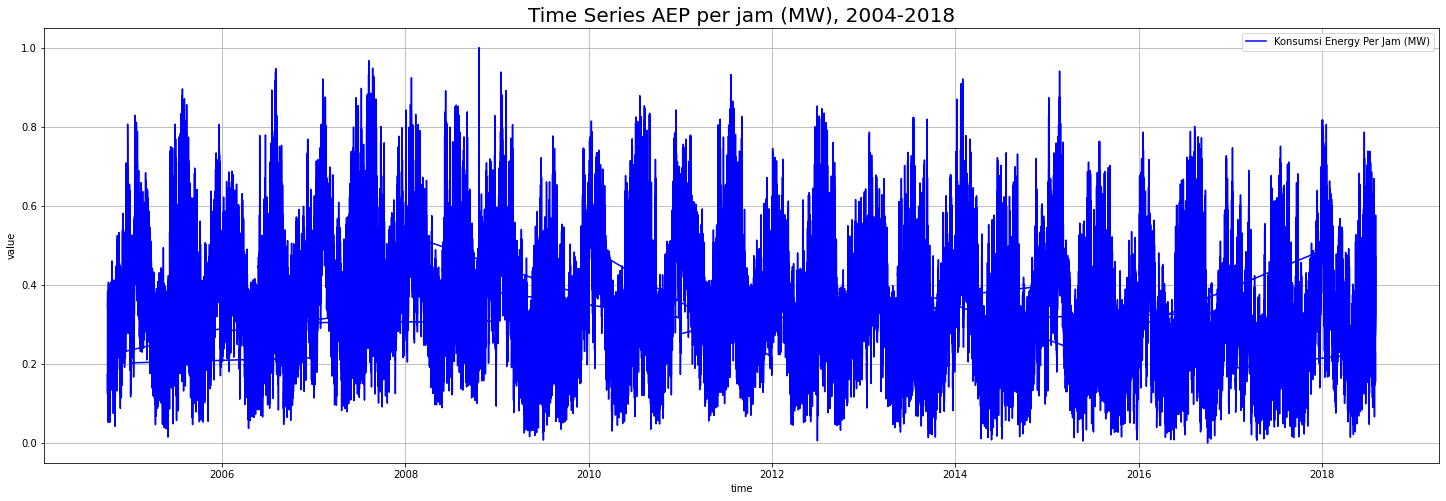

In [7]:
plt.figure(figsize=(25, 8))
plt.plot(reshaped_time, scaled_data, c='b', label='Konsumsi Energy Per Jam (MW)')
plt.title('Time Series AEP per jam (MW), 2004-2018', fontsize=20)
plt.xlabel('time')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

## Data Spliting

Split dataset menjadi train dan test, baik dari value dan juga time.

In [8]:
n_split_data = int(np.floor(len(scaled_data) * .8))

scaled_train = scaled_data[:n_split_data]
scaled_test = scaled_data[n_split_data:]

time_train = time[:n_split_data]
time_test = time[n_split_data:]

scaled_train.shape, scaled_test.shape, time_train.shape, time_test.shape

((97018, 1), (24255, 1), (97018,), (24255,))

Membuat dataset dari series yang ada untuk menentukan berapa sekuens yang dibutuhkan untuk memprediksi waktu berikutnya.

Contoh:

13476, 14376, 28746, 26473, 18763, 17562, 38761, 17628, 17652, 29371, 62828

Dengan misalkan sekuens_len = 4 maka, berikut gambarannya.

| x_train/x_test             | y_train/y_test|
| -------------------------- |:-------------:|
| 13476, 14376, 28746, 26473 | 18763         |
| 14376, 28746, 26473, 18763 | 17562         |
| 28746, 26473, 18763, 17562 | 38761         |
| dst                        | dst           |


In [9]:
def create_dataset(series, sekuens_len):
  datasetX, datasetY = [], []
  
  for i in range(len(series) - sekuens_len - 1):
    x = series[i: (i + sekuens_len), 0]
    y = series[i + sekuens_len, 0]
    datasetX.append(x)
    datasetY.append(y)
  
  return np.array(datasetX), np.array(datasetY)

In [10]:
sekuens_len = 24 * 7

x_train, y_train = create_dataset(scaled_train, sekuens_len)
x_test, y_test = create_dataset(scaled_test, sekuens_len)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((96849, 168), (96849,), (24086, 168), (24086,))

In [11]:
# Reshape untuk menjadikannya [n_sampel, sekuens_len, fitur]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_train.shape, x_test.shape

((96849, 168, 1), (24086, 168, 1))

## Model dan Training

In [12]:
clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sekuens_len, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

learning_rate = 1e-8

# model compiling
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
    metrics=['mae']
)

# callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: learning_rate * 10**(epoch / 25))

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_mae',
    verbose=1
)

# model training
history = model.fit(
    x_train, 
    y_train, 
    epochs=100,
    steps_per_epoch=50,
    validation_data=(x_test, y_test), 
    callbacks=[early_stopping, lr_schedule], 
    batch_size=100 
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
50/50 [==============================] - 3s 65ms/step - loss: 0.0648 - mae: 0.3278 - val_loss: 0.0549 - val_mae: 0.2955
Epoch 2/100
50/50 [==============================] - 2s 50ms/step - loss: 0.0670 - mae: 0.3324 - val_loss: 0.0548 - va

## Evaluation and Prediction

In [13]:
model.evaluate(x_test, y_test)

753/753 [==============================] - 5s 7ms/step - loss: 0.0021 - mae: 0.0509


[0.002114397007972002, 0.05087192356586456]

Melihat hasil dari traning dan juga evaluasi, nilai dari MAE baik di data train maupun di data test sudah di bawah dari 0.1

Selanjutnya, plot history hasil dari training model dengan perbandingan loss dan val_loss, mae dan val_mae di data train dan data test.

In [14]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


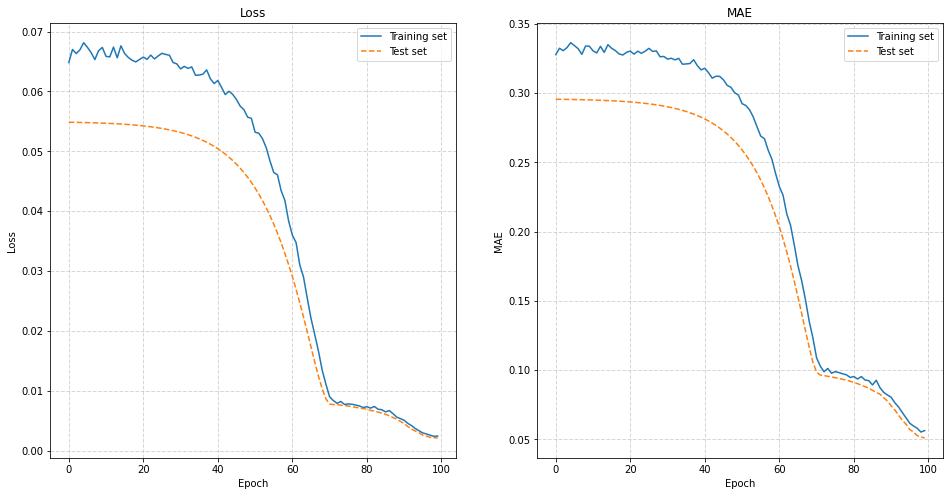

In [15]:
# Mengambil history dari loss dan mae
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']

# Menampilkan graph loss dan mae
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(mae, label='Training set')
plt.plot(val_mae, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

Melakukan prediksi terhadap x_test dan membandingkannya melalui plot time series. Fungsi inverse_transform digunakan untuk mengembalikan nilai hasil scaling ke bentuk semula.

In [16]:
y_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(model.predict(x_test))

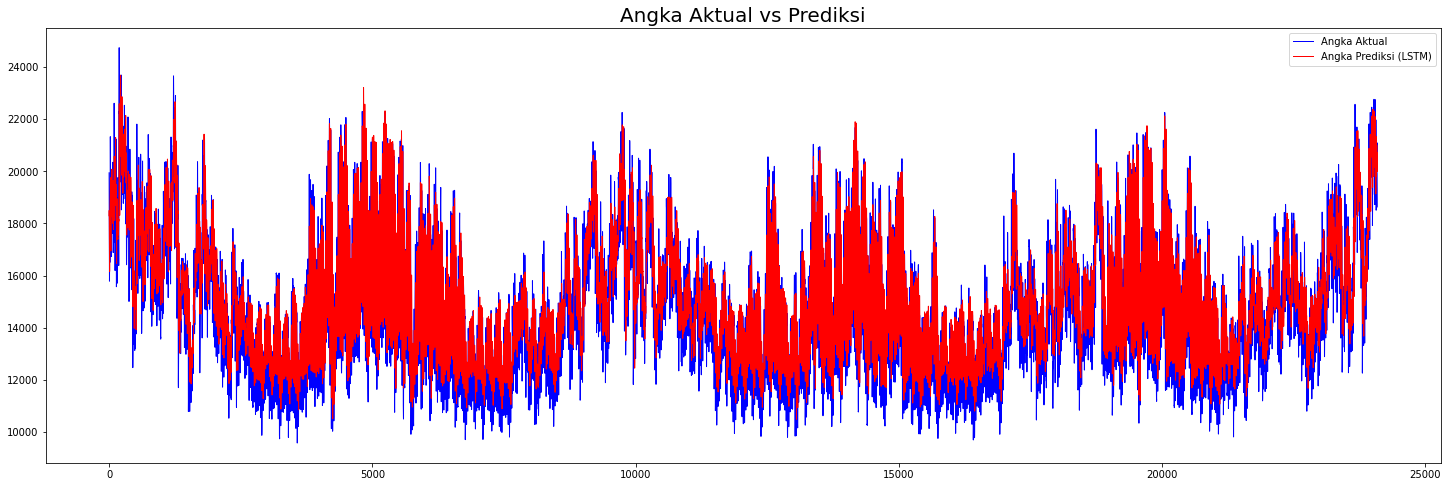

In [17]:
plt.figure(figsize=(25,8))

plt.plot(y_actual, c='b', linewidth=1, label='Angka Aktual')
plt.plot(y_pred, c='r', linewidth=1, label='Angka Prediksi (LSTM)')
plt.legend()
plt.title('Angka Aktual vs Prediksi', fontsize=20)
plt.show()

In [18]:
time_x_test, time_y_test = create_dataset(time_test.reshape(-1,1), sekuens_len)

In [19]:
df = pd.DataFrame({'waktu': time_y_test, 'angka_aktual': y_actual.reshape(-1), 'angka_prediksi': y_pred.reshape(-1)})
df

,waktu,angka_aktual,angka_prediksi
0,2015-02-28 09:00:00,19943.0,18295.029297
1,2015-02-28 10:00:00,19444.0,18460.984375
2,2015-02-28 11:00:00,18792.0,18499.781250
3,2015-02-28 12:00:00,18026.0,18377.515625
4,2015-02-28 13:00:00,17291.0,18094.027344
...,...,...,...
24081,2018-01-01 19:00:00,20925.0,20006.470703
24082,2018-01-01 20:00:00,21089.0,20192.335938
24083,2018-01-01 21:00:00,20999.0,20429.347656
24084,2018-01-01 22:00:00,20820.0,20621.533203
